Phase I - Data cleaning
Raw data overview
+-------------------+---------+-----------+----------------+-------------+--------------+-------------------+---------------------------------------------+
|      Feature      |   Type  | N/A Count | N/A Percentage |   Cat/Num   | Unique Count | Unique Percentage |                   Example                   |
+-------------------+---------+-----------+----------------+-------------+--------------+-------------------+---------------------------------------------+
|      App Name     |  object |     5     |     0.00%      | Categorical |   2177944    |       94.16%      |                 Nyan Roller                 |
|       App Id      |  object |     0     |     0.00%      | Categorical |   2312944    |      100.00%      |      com.princess.SophiaTrafficSpyRider     |
|      Category     |  object |     0     |     0.00%      | Categorical |      48      |       0.00%       |                Music & Audio                |
|       Rating      | 

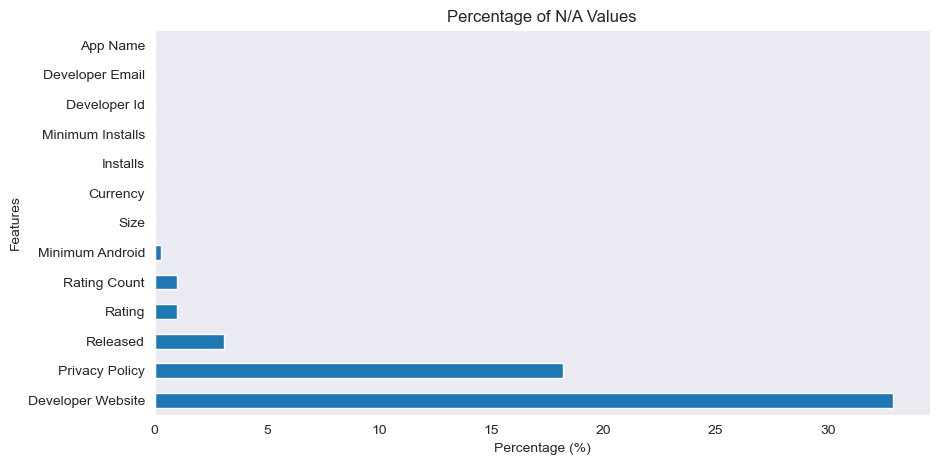

Phase I - Data duplication
Duplication in Currency column
Currency values count
Currency
USD    2311548
XXX       1236
EUR          6
INR          5
GBP          3
CAD          2
VND          1
BRL          1
KRW          1
TRY          1
RUB          1
SGD          1
AUD          1
PKR          1
ZAR          1
Name: count, dtype: int64


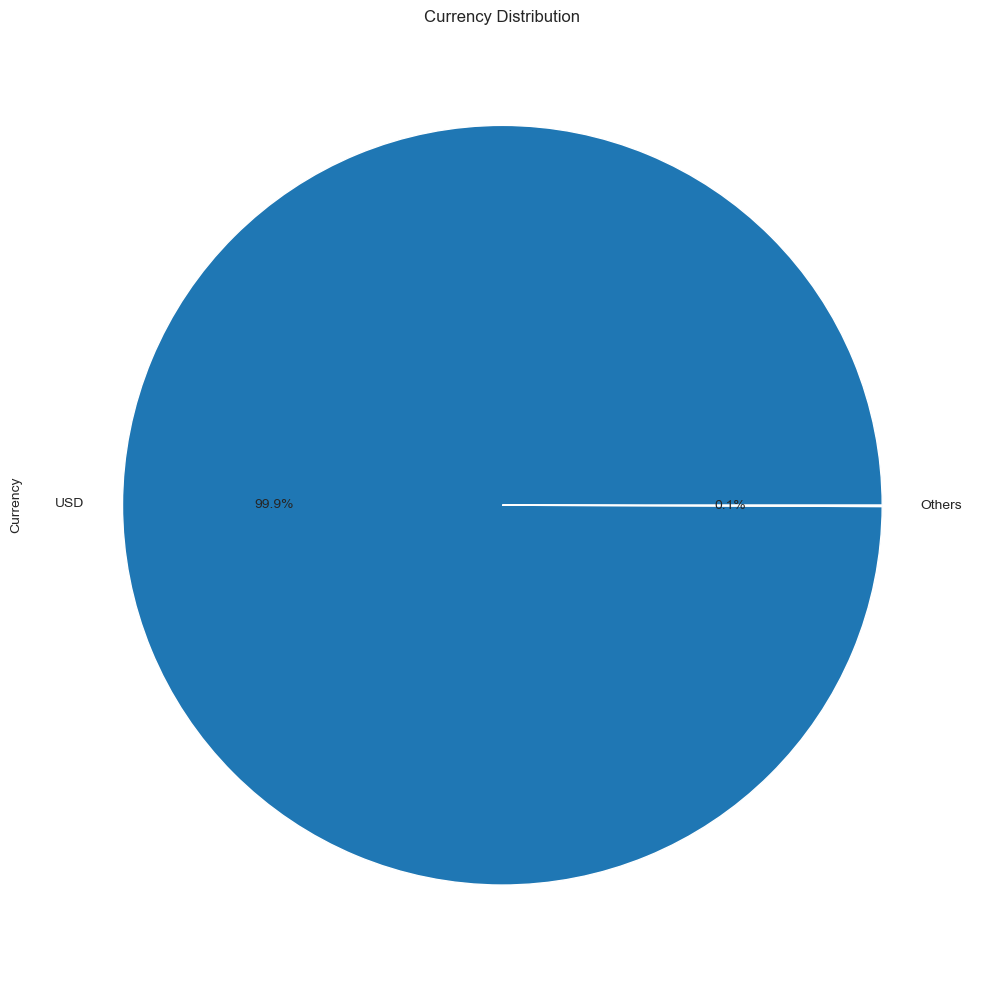

(2311548, 17)
Phase I - Data duplication
Duplication between 'Installs' and 'Minimum Installs'
After conversion, is installs equal to min_installs?
True
Phase I - Aggregation
Aggregation of Android versions.
10M
<class 'str'>
24M
<class 'str'>


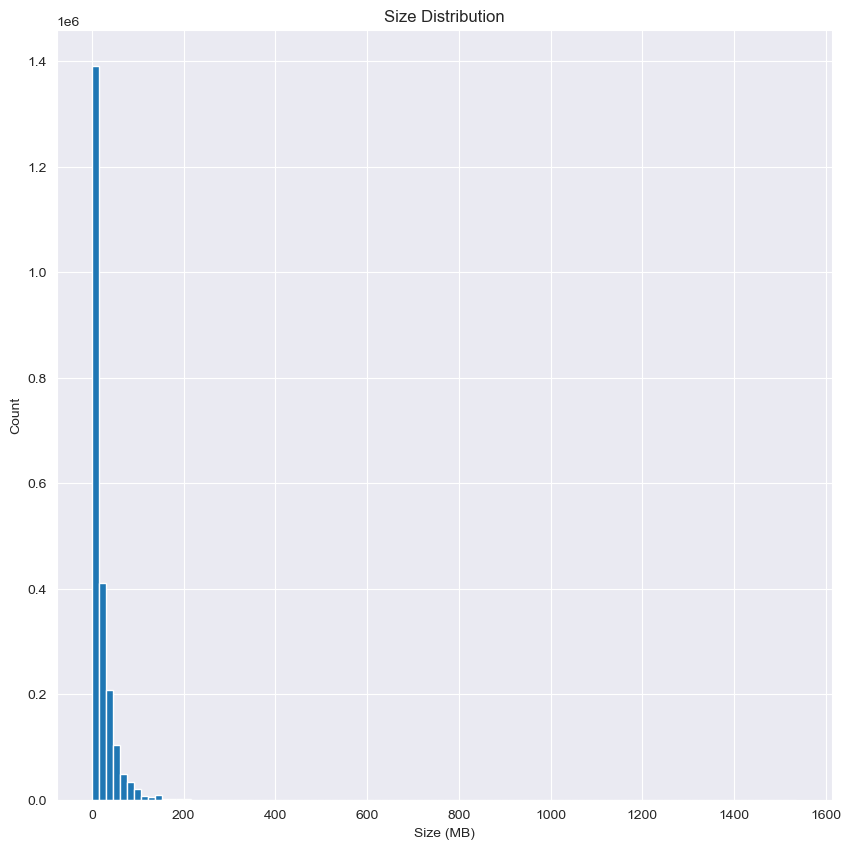

In [17]:
# Google Play Dataset - Preprocessing

import pandas as pd

df = pd.read_csv('../Google-Playstore.csv')

from prettytable import PrettyTable
import random
import time

random.seed(time.time())

feature_outlook = PrettyTable()
feature_outlook.field_names = ["Feature", "Type", "N/A Count", "N/A Percentage", "Cat/Num", "Unique Count",
                               "Unique Percentage", "Example"]


def judge_cat_num(col):
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        return 'Numerical'
    else:
        return 'Categorical'


def check_na_percentage(col):
    ratio = df[col].isna().sum() / len(df[col])
    return f"{ratio:.2%}"


def check_unique_percentage(col):
    ratio = len(df[col].unique()) / len(df[col])
    return f"{ratio:.2%}"


def install_groupby(value):
    if value < 100:
        return '0-100'
    elif value < 1000:
        return '100-1k'
    elif value < 10000:
        return '1k-10k'
    elif value < 100000:
        return '10k-100k'
    else:
        return '100k+'


print("Phase I - Data cleaning")
print("Raw data overview")
for col in df.columns:
    feature_outlook.add_row(
        [col, df[col].dtype, df[col].isna().sum(), check_na_percentage(col), judge_cat_num(col), len(df[col].unique()),
         check_unique_percentage(col), df[col].unique()[random.randint(0, len(df[col].unique()) - 1)]])
print(feature_outlook)

print("Phase I - Data cleaning")
print("NA values percentage")
import matplotlib.pyplot as plt

na_feature_percentage = df.isna().sum().sort_values(ascending=False) / len(df) * 100
na_feature_percentage = na_feature_percentage[na_feature_percentage > 0]
plt.figure(figsize=(10, 5))
na_feature_percentage.plot(kind='barh')
plt.xlabel('Percentage (%)')
plt.ylabel('Features')
plt.title('Percentage of N/A Values')
plt.grid()
plt.show()
df.drop(columns=['Developer Website', 'Developer Email', 'Developer Id','Privacy Policy'], inplace=True)
df.drop(columns=['App Id'], inplace=True)
df.drop(columns=['Free'], inplace=True)
df.drop(columns=['Scraped Time'], inplace=True)

print("Phase I - Data duplication")
print("Duplication in Currency column")
currency_values_count = df['Currency'].value_counts()
print("Currency values count")
print(currency_values_count)
currency_pie = currency_values_count.head(1)
currency_pie['Others'] = currency_values_count[1:].sum()
currency_pie.plot(kind='pie', figsize=(10, 10), autopct='%1.1f%%', labels=['USD', 'Others'], ylabel='Currency',
                  title='Currency Distribution')
plt.tight_layout()
plt.show()

# Drop all non-USD currency
df['Currency'] = df['Currency'].apply(lambda x: 'USD' if x == 'USD' else 'Others')
df.drop(df[df['Currency'] == 'Others'].index, inplace=True)
print(df.shape)
df.drop(columns=['Currency'], inplace=True)

print("Phase I - Data duplication")
print("Duplication between 'Installs' and 'Minimum Installs'")
# Test if installs and min-install are the same
installs = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in x else x)
installs = pd.to_numeric(installs.apply(lambda x: x.replace(',', '') if ',' in x else x))
min_installs = df['Minimum Installs']
min_installs = pd.to_numeric(min_installs)
min_installs = min_installs.astype('int64')
print("After conversion, is installs equal to min_installs?")
print(installs.equals(min_installs))
# Drop 'Installs'
df.drop(columns=['Installs'], inplace=True)

print("Phase I - Aggregation")
print("Aggregation of Android versions.")
# Minimum Android Version
# Replace ' and up' and ' - ' in the entire column
df['Minimum Android'] = df['Minimum Android'].str.replace(' and up', '').str.split(' - ').str.get(0)
df['Minimum Android'] = df['Minimum Android'].str.split('.').str.get(0)
# Replace 'Varies with device' with NaN
df['Minimum Android'] = df['Minimum Android'].apply(lambda x: np.nan if x == 'Varies with device' else x)

# Change Size unit to MB
print(df['Size'][0])
print(type(df['Size'][0]))
print(str(df['Size'][20]))
print(type(df['Size'][20]))


import re

def classify_size_column(value):
    if pd.isna(value) or value == 'Varies with device':
        return np.nan
    match = re.search(r'([0-9.]+)([kMG]?)', str(value))
    if match:
        number, unit = match.groups()
        if unit == 'k':
            return float(number) / 1024
        elif unit == 'G':
            return float(number) * 1024
        else:
            return float(number)
    else:
        return np.nan
    
df['Clean Size'] = df['Size'].apply(classify_size_column)
df['Clean Size'].describe()
plt.figure(figsize=(10, 10))
df['Clean Size'].plot(kind='hist', bins=100)
plt.title('Size Distribution')
plt.xlabel('Size (MB)')
plt.ylabel('Count')
plt.show()
df.drop(columns=['Size'], inplace=True)

# Replace date by age (in days)
df['Released'] = pd.to_datetime(df['Released'], format='%b %d, %Y')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%b %d, %Y')
scraped_time = pd.to_datetime('2021-06-15 00:00:00')
df['App Age'] = (scraped_time - df['Released']).dt.days
# Last update age
df['Last Update Age'] = (scraped_time - df['Last Updated']).dt.days
df.drop(columns=['Released', 'Last Updated'], inplace=True)

df.dropna(inplace=True)
rename_dict = {
    'App Name': 'appName',
    'Category': 'category',
    'Rating': 'rating',
    'Rating Count': 'ratingCount',
    'Maximum Installs': 'installCount',
    'Price': 'priceInUSD',
    'Content Rating': 'contentRating',
    'Ad Supported': 'isAdSupported',
    'In App Purchases': 'isInAppPurchases',
    'Editors Choice': 'isEditorsChoice',
    'Clean Size': 'sizeInMB',
    'Minimum Android': 'minAndroidVersion',
    'Minimum Installs': 'installRange',
    'App Age': 'appAgeInDays',
    'Last Update Age': 'lastUpdateAgeInDays'
    
}
df.rename(columns=rename_dict, inplace=True)


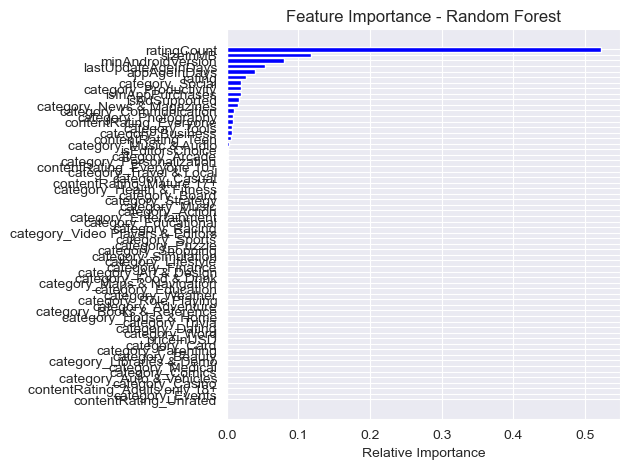

In [18]:
#### Random Forest Analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

rfa_X = df.copy()
rfa_y = df['installCount'].copy()
rfa_X.drop(columns=['installCount','installRange'], inplace=True)
rfa_X.drop(columns=['appName'], inplace=True)
rfa_X = pd.get_dummies(rfa_X, columns=['category', 'contentRating'])
rfa_X_train, rfa_X_test, rfa_y_train, rfa_y_test = train_test_split(rfa_X, rfa_y, test_size=0.2, random_state=5805)

rfa = RandomForestRegressor(random_state=5805, max_depth=10)
rfa.fit(rfa_X_train, rfa_y_train)

rfa_y_pred = rfa.predict(rfa_X_test)
features = rfa_X.columns
importances = rfa.feature_importances_



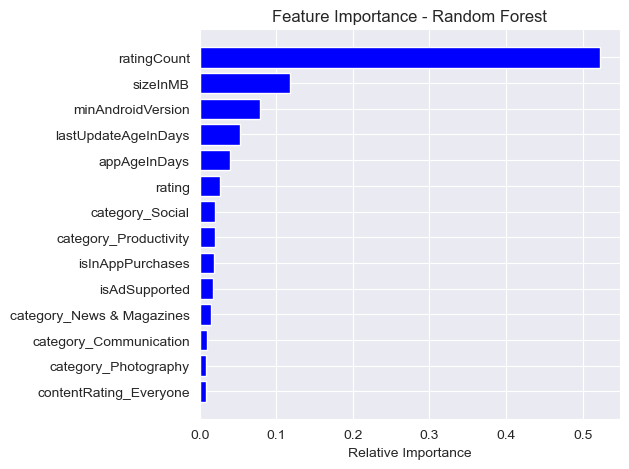

In [21]:
indices = np.argsort(importances)[-14:]
plt.title("Feature Importance - Random Forest")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()